# Inspecting Results

You can interact with a Flyte Cluster using the `FlyteRemote` object, which
is a client that exposes several methods for you to programmatically:

1. Register tasks and workflows
2. Execute tasks and workflows
3. Fetch and inspect task and workflow outputs

In this notebook, we'll grab the model that we trained in the previous step.

## Initializing `FlyteRemote`

We first initialize a `FlyteRemote` object with the configuration needed
to access artifacts from the Flyte sandbox s3 blob store.

In [1]:
from flytekit.remote import FlyteRemote
from flytekit.configuration import Config


remote = FlyteRemote(
    config=Config.auto(),
    default_project="flytesnacks",
    default_domain="development",
)

## Fetching a Workflow Execution

To fetch the workflow execution artifacts, replace the `execution_id = <REPLACE_ME>`
variable with the unique execution id created by Flyte Admin.

For example, after running the `pyflyte run` command,
the execution id can be found in the URL:

```
Go to http://localhost:30080/console/projects/flytesnacks/domains/development/executions/<EXECUTION_ID> to see execution in the console.
```

In [2]:
execution_id = "f6c85dfee56814bfdb79"
execution = remote.fetch_execution(name=execution_id)
remote.sync(execution, sync_nodes=True)

# get execution output keys
execution.outputs.keys()

KeysView(Partially converted to native values, call get(key, <type_hint>) to convert rest...
{
  o0: 
      scalar {
        blob {
          metadata {
            type {
              format: "PythonPickle"
            }
          }
          uri: "s3://my-s3-bucket/test/rn/f6c85dfee56814bfdb79-n2-0/c049b0571853df029db0c35bb703dab7/1b5296874274f3bc9ef2c31b606ccb8a"
        }
      }

})

As you can see, `execution.outputs` is a dict-like object with a single
key `"o0"`, which we can use to access the sklearn model object we just
trained.

In [4]:
model = execution.outputs["o0"]
model

LogisticRegression(max_iter=1000)

## Fetching Intermediate Results

You can also fetch intermediate results of the tasks in our workflow. For example, if we want to visualize the difference in distribution of class targets between our raw processed data, we can do the following:

In [5]:
execution.node_executions.keys()

dict_keys(['end-node', 'n0', 'n1', 'n2', 'start-node'])

As you can see, Flyte has an implicit `start-node` and `end-node` that marks
the beginning and end of a workflow, with `n*` nodes to represent tasks in
between. We know that the `get_data` task was the `0th` node and the `process_data`
task was the `1st` node in our workflow:

In [15]:
import os
import pandas as pd

# get raw data
raw_data = execution.node_executions["n0"].outputs["o0"]
raw_data = raw_data.open(pd.DataFrame).all()

# get processed data
processed_data = execution.node_executions["n1"].outputs["o0"]
processed_data = processed_data.open(pd.DataFrame).all()

Then, we simply plot the classes to see that we successfully aggregated
class `1` and `2` to a single class of `1`.

<AxesSubplot: title={'center': 'processed data'}>

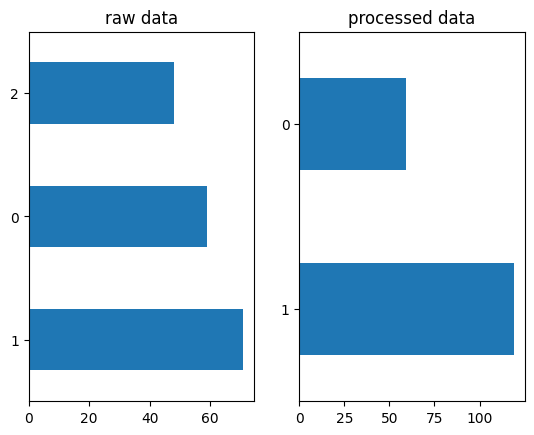

In [24]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2)
raw_data["target"].value_counts().plot.barh(ax=axes[0], title="raw data")
processed_data["target"].value_counts().plot.barh(ax=axes[1], title="processed data")